In [166]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from lightgbm.sklearn import LGBMRegressor
import logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)
 
from sklearn.metrics import mean_squared_error, make_scorer
seed = np.random.seed(42)

## 1. Data Visualization

In [167]:
train = pd.read_csv('resources/train.csv')
test = pd.read_csv('resources/test.csv')

In [168]:
categorical_features = train.select_dtypes(include='object').columns.to_list()
numeric_features = train.select_dtypes(include='number').columns.to_list()[1:-1]
features = numeric_features + categorical_features

In [169]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            # ('scaler', MinMaxScaler())
        ]), numeric_features),
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), categorical_features),
    ], 
    verbose=True,
    # remainder='passthrough'
)

In [170]:
train_transformed = preprocessor.fit_transform(train)
train_transformed = pd.DataFrame(train_transformed,columns=features)

[ColumnTransformer] ....... (1 of 2) Processing numeric, total=   0.0s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   0.0s


In [171]:
train_transformed.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
5,50.0,85.0,14115.0,5.0,5.0,1993.0,1995.0,0.0,732.0,0.0,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
6,20.0,75.0,10084.0,8.0,5.0,2004.0,2005.0,186.0,1369.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
7,60.0,69.0,10382.0,7.0,6.0,1973.0,1973.0,240.0,859.0,32.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
8,50.0,51.0,6120.0,7.0,5.0,1931.0,1950.0,0.0,0.0,0.0,...,5.0,2.0,1.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
9,190.0,50.0,7420.0,5.0,6.0,1939.0,1950.0,0.0,851.0,0.0,...,1.0,1.0,2.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


## 2. Data Preprocessing

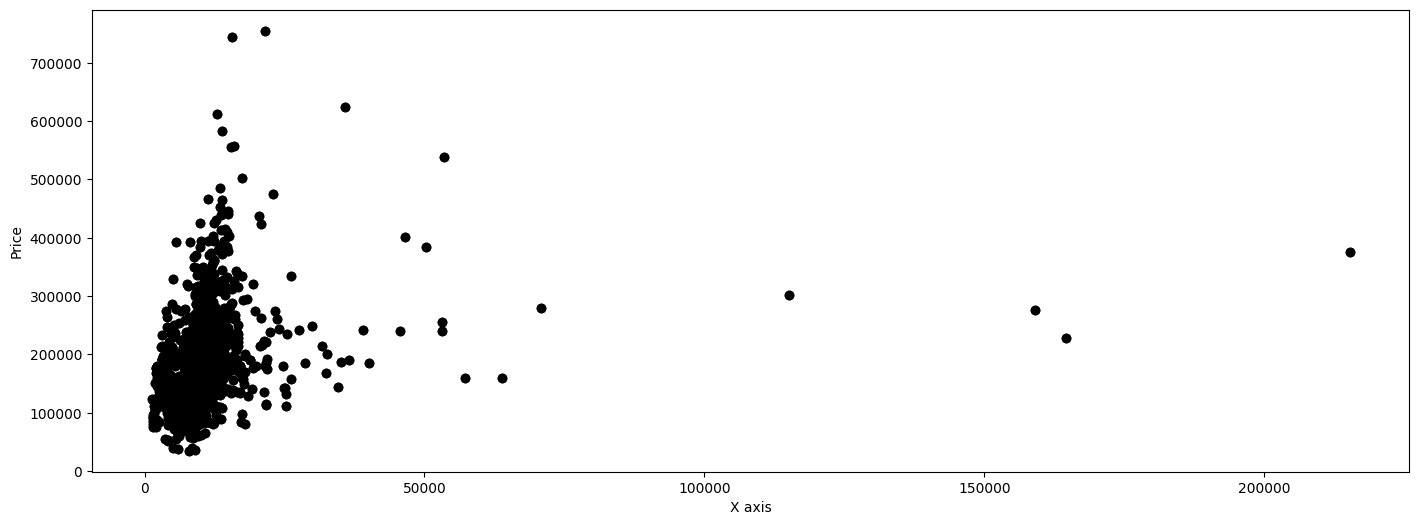

In [172]:
plt.figure(figsize=(17, 6))  
plt.scatter(train['LotArea'],train['SalePrice'],color='black')
plt.scatter(train['LotArea'],train['SalePrice'],color='black')
plt.xlabel('X axis')
plt.ylabel('Price')
plt.show()

## 2.2 Corelation Analysis

In [173]:
correlation_matrix = train_transformed.corr()

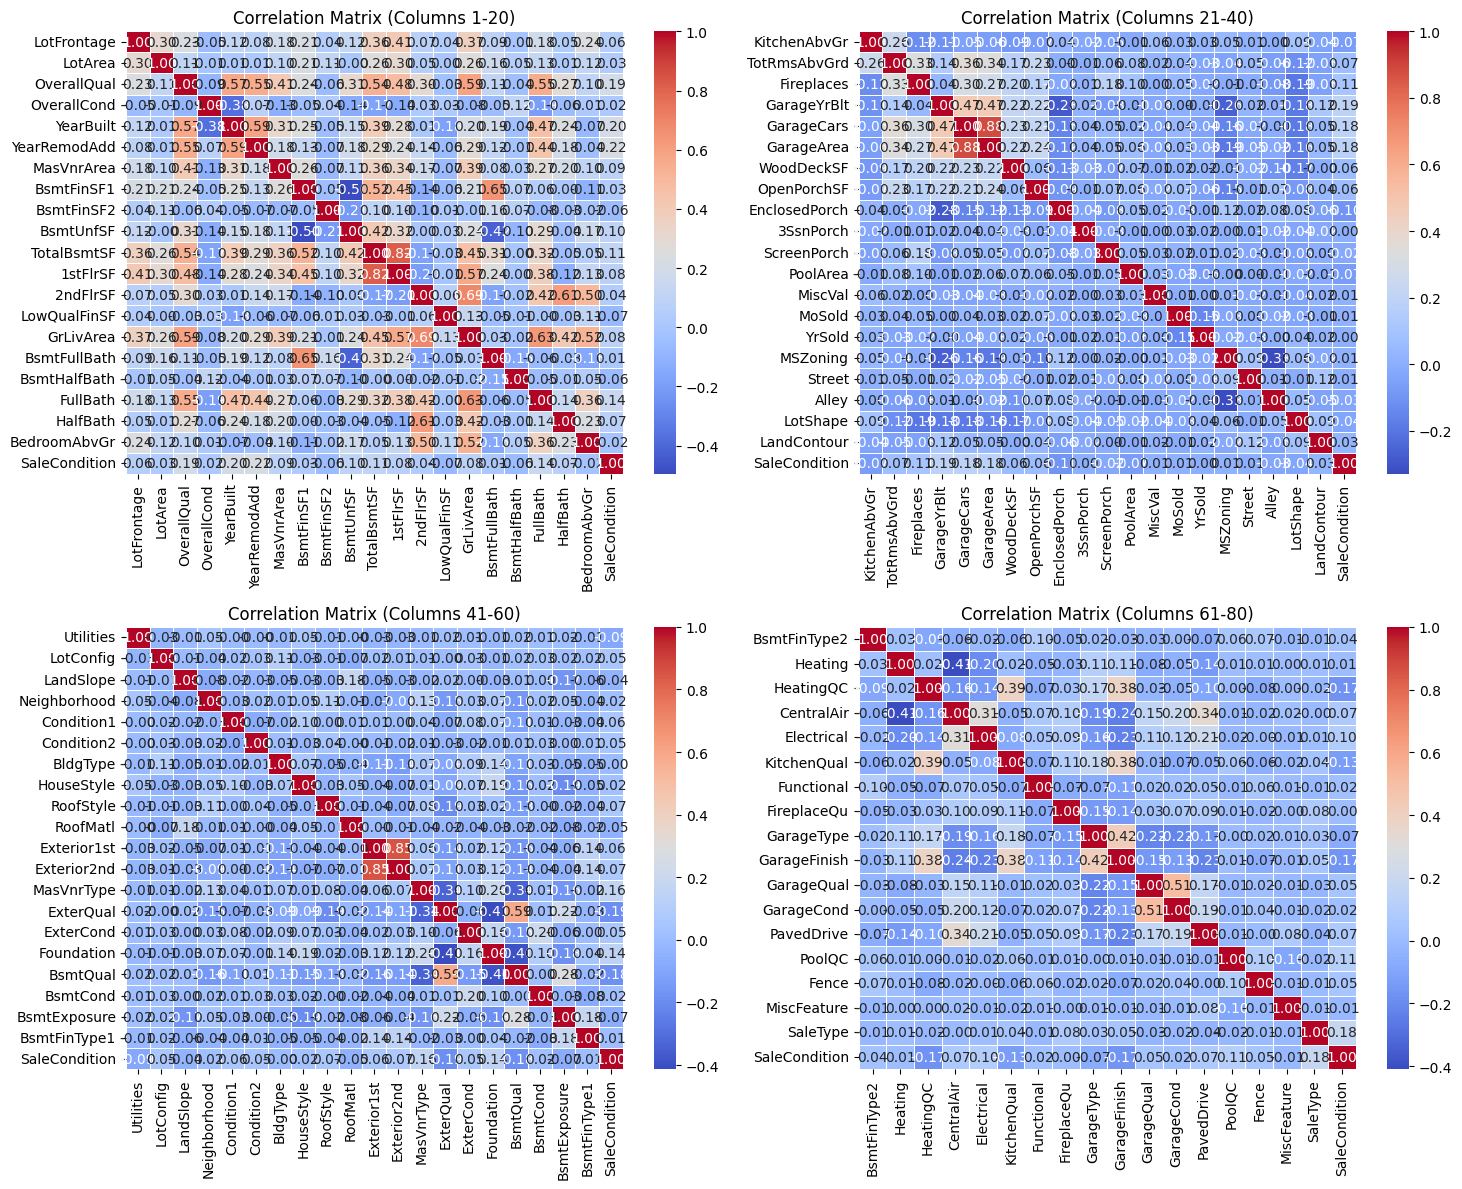

In [174]:

correlation_20 = train_transformed.columns[1:21].tolist() + [train_transformed.columns[-1]]
correlation_40 = train_transformed.columns[21:41].tolist() + [train_transformed.columns[-1]]
correlation_60 = train_transformed.columns[41:61].tolist() + [train_transformed.columns[-1]]
correlation_80 = train_transformed.columns[61:81].tolist()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

sns.heatmap(
    correlation_matrix.loc[correlation_20, correlation_20],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_20, yticklabels=correlation_20,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Correlation Matrix (Columns 1-20)')

sns.heatmap(
    correlation_matrix.loc[correlation_40, correlation_40],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_40, yticklabels=correlation_40,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Correlation Matrix (Columns 21-40)')

sns.heatmap(
    correlation_matrix.loc[correlation_60, correlation_60],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_60, yticklabels=correlation_60,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Correlation Matrix (Columns 41-60)')

sns.heatmap(
    correlation_matrix.loc[correlation_80, correlation_80],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_80, yticklabels=correlation_80,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Correlation Matrix (Columns 61-80)')

plt.tight_layout()
plt.show()


## 2.3 Feature extraction

In [175]:
last_column_correlations = correlation_matrix.iloc[:-1, -1]
most_correlated_features = last_column_correlations.abs().sort_values(ascending=False).index

In [176]:
train.loc[:,most_correlated_features[:40]].head()

,YearRemodAdd,YearBuilt,OverallQual,GarageYrBlt,ExterQual,GarageCars,BsmtQual,SaleType,GarageArea,HeatingQC,...,TotRmsAbvGrd,GarageType,Exterior2nd,PoolArea,KitchenAbvGr,RoofStyle,Exterior1st,OpenPorchSF,BsmtHalfBath,BsmtFinSF2
0,2003,2003,7,2003.0,Gd,2,Gd,WD,548,Ex,...,8,Attchd,VinylSd,0,1,Gable,VinylSd,61,0,0
1,1976,1976,6,1976.0,TA,2,Gd,WD,460,Ex,...,6,Attchd,MetalSd,0,1,Gable,MetalSd,0,1,0
2,2002,2001,7,2001.0,Gd,2,Gd,WD,608,Ex,...,6,Attchd,VinylSd,0,1,Gable,VinylSd,42,0,0
3,1970,1915,7,1998.0,TA,3,TA,WD,642,Gd,...,7,Detchd,Wd Shng,0,1,Gable,Wd Sdng,35,0,0
4,2000,2000,8,2000.0,Gd,3,Gd,WD,836,Ex,...,9,Attchd,VinylSd,0,1,Gable,VinylSd,84,0,0


In [177]:
class TudisFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, features= None, features_no=1):
        self.features = features 
        self.features_no = features_no
       
    def fit(self, X,):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X,columns=features)
        correlated_features = self.features[:self.features_no]
        X = X.loc[:,correlated_features].to_numpy()
        return X

In [178]:
pip = Pipeline([
    ('preprocessor',preprocessor),
    ('extractor',TudisFeatureExtractor(features=most_correlated_features,features_no=79)),
], 
verbose=True
)

X_train = pip.transform(train)

In [179]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train['SalePrice'].values, test_size=0.1, shuffle=True,random_state=seed)
# y_train = train['SalePrice'].values

## 3. Model selection

In [182]:

models = {
    'XGB': XGBRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    'RF': RandomForestRegressor(random_state=seed),
    'LGB': LGBMRegressor(random_state=seed),
}


param_grids = {
     'XGB': {
        'max_depth': [3],
        'learning_rate': [0.06],
        'n_estimators': [250],
        'eval_metric': ['rmse']
    },
    'GB': {
        'loss': ['huber'],
        'learning_rate': [0.08],
        'n_estimators' :[250]
    },
    'RF': {
        'n_estimators':[120,150],
        'criterion': ['friedman_mse']        
    },
    'LGB': {
        'num_leaves': [31],
        'learning_rate':[0.08],
        'n_estimators': [100],
        'objective': ['regression'],
    }
}


## 4. Training and Validation

## 4.1 Scoring method

In [183]:
def root_mean_squared_log_error(y_true, y_pred):
    log1p_true = np.log1p(y_true)
    log1p_pred = np.log1p(y_pred)
    
    squared_log_errors = (log1p_true - log1p_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    
    return np.sqrt(mean_squared_log_error)

In [184]:
best_models = {}
best_score = float('inf')
best_model = None 
custom_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [185]:
import contextlib

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    with contextlib.redirect_stdout(None):
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=5,
            scoring=custom_scorer,
            verbose=False,
            return_train_score=True,
        )

        grid_search.fit(X_train, y_train)
        cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    # pretty-print model configurations
    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[XGB]:	0.13099905349090088		{'eval_metric': 'rmse', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 250}	
[GB]:	0.13327582854671652		{'learning_rate': 0.08, 'loss': 'huber', 'n_estimators': 250}	
[RF]:	0.1469032015311593		{'criterion': 'friedman_mse', 'n_estimators': 120}	
[RF]:	0.14548204907569834		{'criterion': 'friedman_mse', 'n_estimators': 150}	
[LGB]:	0.13376804957169286		{'learning_rate': 0.08, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression'}	


In [186]:
ensemble_clf = VotingRegressor(
 # GOTTA love democracy
    estimators=[
        ('GB',best_models['GB']),
        ('XGB',best_models['XGB']),
        ('RF',best_models['RF']),
        ('LGB',best_models['LGB']),
    ],
    verbose=True,
)

In [ ]:
param_grid = {
    'weights': [
        [0.25, 0.25, 0.25, 0.25], 
        [0.25, 0.25, 0.25, 0.75],  
        [0.2, 0.2, 0.2, 0.4],    
               ],
}

In [ ]:
grid_search_ensemble = GridSearchCV(
    ensemble_clf,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    verbose=2,  
    n_jobs=-1,  
)

grid_search_ensemble.fit(X_train, y_train)
cv_results = grid_search_ensemble.cv_results_

print("=" * 170)
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"[{params}]:\t\t{abs(mean_score)}")

In [188]:
y_pred = ensemble_clf.predict(X_val)
rMSE = root_mean_squared_log_error(y_val,y_pred)
print("[rMSE]:\t\t", rMSE)

[rMSE]:		 0.11516975623010815


In [189]:
X_test = pip.transform(test)
test_preds = ensemble_clf.predict(X_test)

## 4. Metrics

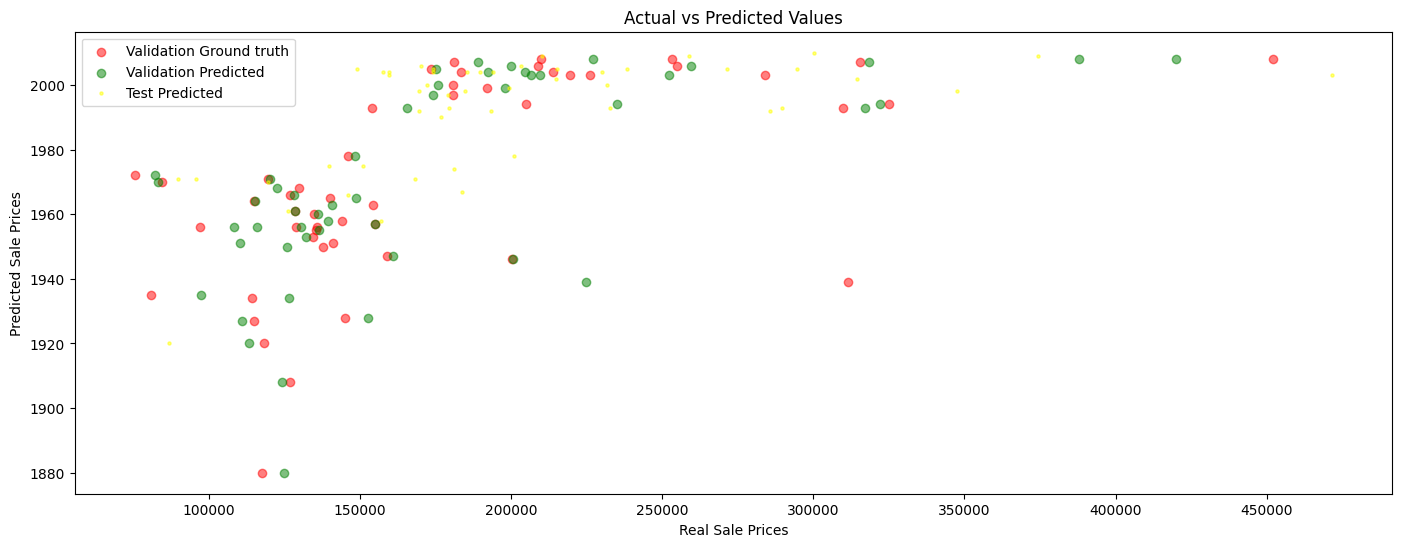

In [190]:
plt.figure(figsize=(17, 6))
plt.scatter(y_val[:50],X_val[:50,1], alpha=0.5, label='Validation Ground truth',color='red')
plt.scatter(y_pred[:50],X_val[:50,1], alpha=0.5, label='Validation Predicted',color='green')
plt.scatter(test_preds[:50],X_test[:50,1], alpha=0.5, label='Test Predicted',color='yellow',s=5)
plt.xlabel('Real Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## KAGGLE

In [191]:
submission_data = np.column_stack((test.iloc[:,0],test_preds))

np.savetxt('kaggle.csv', submission_data, delimiter=',', header='Id,SalePrice', fmt='%d,%.4f', comments='')